In [1]:
from collections import deque
import numpy as np
import numpy.linalg as la

import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

import modern_robotics as mr

import networkx as nx

from description.kinematics import JointPoint

from dataclasses import dataclass, field


@dataclass
class Link:
    name: str = ""
    joints: set[JointPoint] = field(default_factory=set)
    instance_counter: int = 0

    def __post_init__(self):
        Link.instance_counter += 1
        self.instance_counter = Link.instance_counter
        if self.name == "":
            self.name = "L" + str(self.instance_counter)

    def __hash__(self) -> int:
        return hash((self.name, *self.joints))

    def __eq__(self, __value: object) -> bool:
        self.joints == __value.joints


def get_pos(G: nx.Graph):
    pos = {}
    for node in G:
        pos[node] = [node.r[0], node.r[2]]

    return pos


def plot_link(L: Link, graph: nx.Graph):
    sub_g_l = graph.subgraph(L.joints)
    pos = get_pos(sub_g_l)
    nx.draw(
        sub_g_l,
        pos,
        node_color="b",
        linewidths=1.5,
        edge_color="b",
        node_shape="o",
        node_size=100,
        width=5,
        with_labels=False,
    )

In [2]:
# https://cad.onshape.com/documents/52eb11422c701d811548a6f5/w/655758bb668dff773a0e7c1a/e/77ff7f84e82d8fb31fe9c30b
# abs_ground = np.array([0.065, 0, -0.015])
abs_ground = np.array([0.065, 0, -0.047])
pos_toeA_joint = np.array([0.060, 0, -0.052]) - abs_ground
pos_toeA_tarus_joint = np.array([-0.273, 0, -0.350]) - abs_ground
pos_shin_joint = np.array([0.021, 0, -0.159]) - abs_ground
pos_knee_spring = np.array([0.011, 0, -0.219]) - abs_ground
pos_tarus_joint = np.array([-0.237, 0, -0.464]) - abs_ground
pos_foot_joint = np.array([-0.080, 0, -0.753]) - abs_ground
pos_molet_joint = np.array([-0.207, 0, -0.552]) - abs_ground
pos_toeB_joint = np.array([-0.257, 0, -0.579]) - abs_ground
pos_toeB_foot_joint = np.array([-0.118, 0, -0.776]) - abs_ground

ground_joint = JointPoint(
    r=np.zeros(3), w=np.array([0, 1, 0]), attach_ground=True, active=True
)
shin_joint = JointPoint(r=pos_shin_joint, w=np.array([0, 1, 0]), active=True)
knee_spring = JointPoint(pos_knee_spring, w=np.array([0, 1, 0]), weld=True)
tarus_joint = JointPoint(r=pos_tarus_joint, w=np.array([0, 1, 0]))
foot_joint = JointPoint(
    r=pos_foot_joint, w=np.array([0, 1, 0]), attach_endeffector=True
)

toeA_joint = JointPoint(r=pos_toeA_joint, w=np.array([0, 1, 0]))
connect_toeA_tarus_joint = JointPoint(
    r=pos_toeA_tarus_joint, w=np.array([0, 1, 0]), weld=True
)

molet_joint = JointPoint(r=pos_molet_joint, w=np.array([0, 1, 0]), active=True)
toeB_joint = JointPoint(r=pos_toeB_joint, w=np.array([0, 1, 0]))
toeB_foot_joint = JointPoint(
    r=pos_toeB_foot_joint, w=np.array([0, 1, 0]), attach_endeffector=True
)

jts = [
    ground_joint,
    shin_joint,
    knee_spring,
    tarus_joint,
    foot_joint,
    toeA_joint,
    connect_toeA_tarus_joint,
    molet_joint,
    toeB_joint,
    toeB_foot_joint,
]

In [3]:
graphs: list[nx.Graph] = [nx.Graph() for __ in range(6)]
f_links: list[Link] = [Link() for __ in range(6)]

elist = [(jts[0], jts[2]), (jts[2], jts[1])]
graphs[0].add_edges_from(elist)
f_links[0].joints.add(jts[0])
f_links[0].joints.add(jts[2])

elist = [(jts[0], jts[2]), (jts[2], jts[1]), (jts[2], jts[3]), (jts[1], jts[3])]
graphs[1].add_edges_from(elist)
f_links[1].joints.add(jts[0])
f_links[1].joints.add(jts[2])


elist = [(jts[0], jts[2]), (jts[2], jts[1]), (jts[1], jts[0]), (jts[2], jts[3])]
graphs[2].add_edges_from(elist)
f_links[2].joints.add(jts[0])
f_links[2].joints.add(jts[1])
f_links[2].joints.add(jts[2])

elist = [
    (jts[0], jts[2]),
    (jts[2], jts[1]),
    (jts[1], jts[0]),
    (jts[2], jts[3]),
    (jts[1], jts[3]),
]
graphs[3].add_edges_from(elist)
f_links[3].joints.add(jts[0])
f_links[3].joints.add(jts[1])
f_links[3].joints.add(jts[2])

elist = [
    (jts[0], jts[2]),
    (jts[2], jts[1]),
    (jts[1], jts[0]),
    (jts[2], jts[3]),
    (jts[2], jts[4]),
    (jts[3], jts[4]),
]
graphs[4].add_edges_from(elist)
f_links[4].joints.add(jts[0])
f_links[4].joints.add(jts[1])
f_links[4].joints.add(jts[2])

elist = [
    (jts[0], jts[2]),
    (jts[2], jts[1]),
    (jts[1], jts[0]),
    (jts[2], jts[3]),
    (jts[3], jts[1]),
    (jts[2], jts[4]),
]
graphs[5].add_edges_from(elist)
f_links[5].joints.add(jts[0])
f_links[5].joints.add(jts[1])
f_links[5].joints.add(jts[2])

In [38]:
num = 1
g = graphs[num]
nx.draw(
    g,
    get_pos(g),
    node_color="w",
    linewidths=3.5,
    edgecolors="k",
    node_shape="o",
    node_size=150,
    width=3,
    with_labels=False,
)
plot_link(f_links[num], g)

NameError: name 'graphs' is not defined

In [5]:
curr_j = jts[2]

for G, L in zip(graphs, f_links):
    L1 = G.subgraph(L.joints)
    N = set(G.neighbors(curr_j)) - L.joints
    nextN = {}
    lenNN = {}
    for n in N:
        nextN[n] = set(G.neighbors(n))
        lenNN[n.name] = len(nextN[n] & L.joints)
    print(f"Lj: {len(L.joints)}, Nj: {len(set(N))} NN: {lenNN}")

Lj: 2, Nj: 1 NN: {'J2': 1}
Lj: 2, Nj: 2 NN: {'J4': 1, 'J2': 1}
Lj: 3, Nj: 1 NN: {'J4': 1}
Lj: 3, Nj: 1 NN: {'J4': 2}
Lj: 3, Nj: 2 NN: {'J4': 1, 'J5': 1}
Lj: 3, Nj: 2 NN: {'J4': 2, 'J5': 1}


In [3]:
graph = nx.Graph()
for j in jts:
    graph.add_node(j)
main_branch = [ground_joint, shin_joint, knee_spring, tarus_joint, foot_joint]
add_branch_1 = [
    [ground_joint, shin_joint],
    toeA_joint,
    connect_toeA_tarus_joint,
    [tarus_joint, foot_joint],
]
add_branch_2 = [
    [tarus_joint, foot_joint],
    molet_joint,
    toeB_joint,
    toeB_foot_joint,
    foot_joint,
]

for id in range(len(main_branch) - 1):
    graph.add_edge(main_branch[id], main_branch[id + 1], variable=False, active=False)
for id in range(len(add_branch_1) - 1):
    if isinstance(add_branch_1[id], list):
        for j in add_branch_1[id]:
            graph.add_edge(j, add_branch_1[id + 1], variable=False, active=False)
    elif isinstance(add_branch_1[id + 1], list):
        for j in add_branch_1[id + 1]:
            graph.add_edge(j, add_branch_1[id], variable=False, active=False)
    else:
        graph.add_edge(
            add_branch_1[id], add_branch_1[id + 1], variable=False, active=False
        )
for id in range(len(add_branch_2) - 1):
    if isinstance(add_branch_2[id], list):
        for j in add_branch_2[id]:
            graph.add_edge(j, add_branch_2[id + 1], variable=False, active=False)
    elif isinstance(add_branch_2[id + 1], list):
        for j in add_branch_2[id + 1]:
            graph.add_edge(j, add_branch_2[id], variable=False, active=False)
    else:
        graph.add_edge(
            add_branch_2[id], add_branch_2[id + 1], variable=False, active=False
        )

In [4]:
R0 = 0.751618254168963
ground_joints = set(
    sorted(filter(lambda n: n.attach_ground, jts), key=lambda x: la.norm(x.r))
)
ee_joints = set(
    sorted(
        filter(lambda n: n.attach_endeffector, jts),
        key=lambda x: np.abs(la.norm(x.r) - R0),
    )
)

ground_link = Link("G", ground_joints)
ee_link = Link("EE", ee_joints)

In [5]:
stack_joints: deque[JointPoint] = deque(maxlen=len(graph.nodes()))

stack_joints += list([ground_joint])
j2link: dict[JointPoint, set[Link]] = {j: set() for j in graph.nodes()}
for j in ground_joints:
    j2link[j].add(ground_link)
for ee_j in ee_joints:
    j2link[ee_j].add(ee_link)

exped_j = set()
links: list[Link] = [ee_link, ground_link]

while stack_joints:
    curr_j = stack_joints.pop()
    L = next(iter(j2link[curr_j]))
    exped_j.add(curr_j)
    L1 = graph.subgraph(L.joints)
    N = set(graph.neighbors(curr_j)) - L.joints
    nextN = {}
    lenNN = {}
    for n in N:
        nextN[n] = set(graph.neighbors(n))
        lenNN[n] = len(nextN[n] & L.joints)
        j2link[n]
    if len(L.joints) <= 2:
        L2 = Link(joints=(N | set([curr_j])))
        for j in L2.joints:
            j2link[j].add(L2)
    elif len(N) == 1:
        N = N.pop()
        if lenNN[n] == 1:
            L2 = Link(joints=set([N, curr_j]))
            for j in L2.joints:
                j2link[j].add(L2)
        else:
            L1.joints.add(n)
            j2link[n].add(L1)
            continue
    else:
        more_one_adj_L1 = set(filter(lambda n: lenNN[n] > 1, N))
        for n in more_one_adj_L1:
            L1.joints.add(n)
            j2link[n].add(L1)
        less_one_adj_L1 = N - more_one_adj_L1
        if len(less_one_adj_L1):
            raise Exception("More 2 links to one joints")
        N = less_one_adj_L1.pop()
        L2 = Link(joints=set([N, curr_j]))
        j2link[N].add(L2)
    links.append(L2)
    if isinstance(N, set):
        intersting_joints = set(filter(lambda n: len(j2link[n]) < 2, N))
        stack_joints += list(intersting_joints)
    else:
        intersting_joints = N if len(j2link[N]) < 2 else set()
        stack_joints.append(N)
    # tuple_j_l = list(map(lambda jl: (jl[0].name,) + tuple(l.name for l in jl[1]), j2link.items()))
    # # for jl in tuple_j_l:
    # #     print(jl)
    # print([j.name for j in stack_joints])
    stack_joints = deque(filter(lambda j: len(j2link[j]) < 2, stack_joints))
    # print([j.name for j in stack_joints])
    # print()

J10 [-0.183  0.    -0.729]
J5 [-0.145  0.    -0.706]


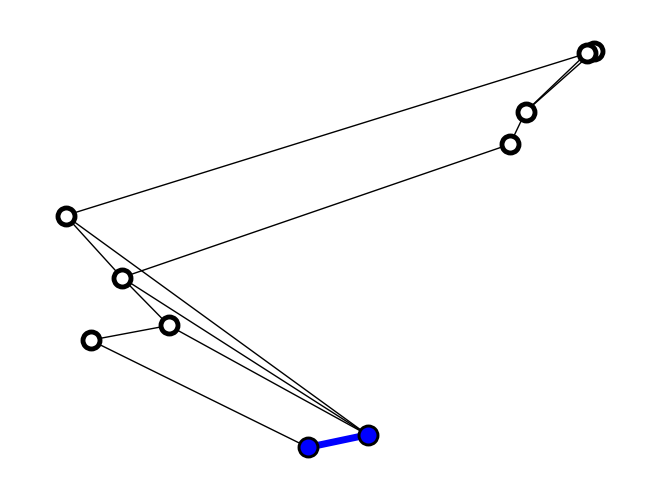

In [6]:
num = 0
nx.draw(
    graph,
    get_pos(graph),
    node_color="w",
    linewidths=3.5,
    edgecolors="k",
    node_shape="o",
    node_size=150,
    with_labels=False,
)
plot_link(links[num], graph)
for j in links[num].joints:
    print(j.name, j.r)

In [7]:
from itertools import combinations

kin_graph = nx.Graph()
for l in links:
    kin_graph.add_node(l.name, link=l)
pairs = combinations(links, 2)
# list_edges = list(map(lambda x: tuple(x), filter(lambda x: len(x[0].joints & x[1].joints)>0, pairs)))
list_edges = filter(lambda x: len(x[0].joints & x[1].joints) > 0, pairs)
list_edges = list(
    map(lambda x: x + tuple([(x[0].joints & x[1].joints).pop()]), list_edges)
)

In [8]:
for edge in list_edges:
    if edge[-1].active:
        w = 1
    else:
        w = 0.5
    # norm =
    kin_graph.add_edge(edge[0].name, edge[1].name, joint=edge[-1], weight=w)

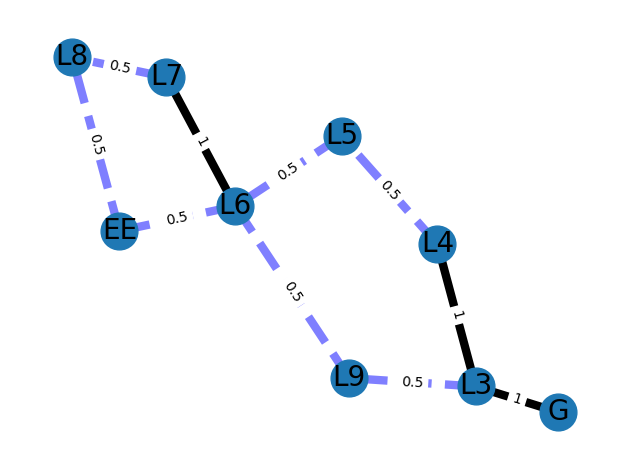

In [9]:
elarge = [(u, v) for (u, v, d) in kin_graph.edges(data=True) if d["weight"] > 0.5]
esmall = [(u, v) for (u, v, d) in kin_graph.edges(data=True) if d["weight"] <= 0.5]
pos = nx.spring_layout(kin_graph, seed=7)
nx.draw_networkx_nodes(kin_graph, pos, node_size=700)
nx.draw_networkx_edges(kin_graph, pos, edgelist=elarge, width=6)
nx.draw_networkx_edges(
    kin_graph, pos, edgelist=esmall, width=6, alpha=0.5, edge_color="b", style="dashed"
)
nx.draw_networkx_labels(kin_graph, pos, font_size=20, font_family="sans-serif")
# edge weight labels
edge_labels = nx.get_edge_attributes(kin_graph, "weight")
nx.draw_networkx_edge_labels(kin_graph, pos, edge_labels)
ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

In [10]:
span_tree = nx.maximum_spanning_tree(kin_graph, algorithm="prim")

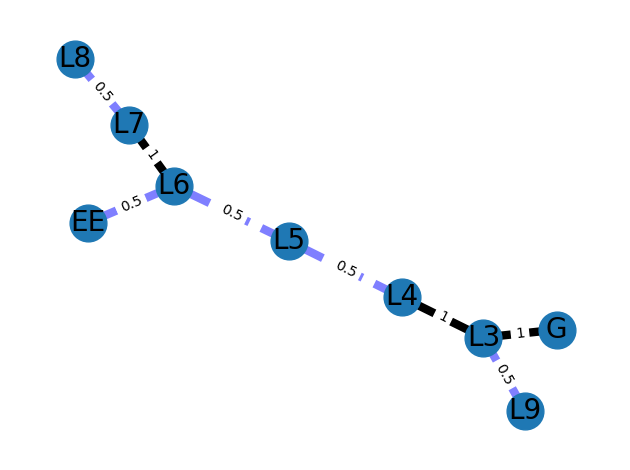

In [11]:
elarge = [(u, v) for (u, v, d) in span_tree.edges(data=True) if d["weight"] > 0.5]
esmall = [(u, v) for (u, v, d) in span_tree.edges(data=True) if d["weight"] <= 0.5]
pos = nx.spring_layout(span_tree, seed=7)
nx.draw_networkx_nodes(span_tree, pos, node_size=700)
nx.draw_networkx_edges(span_tree, pos, edgelist=elarge, width=6)
nx.draw_networkx_edges(
    span_tree, pos, edgelist=esmall, width=6, alpha=0.5, edge_color="b", style="dashed"
)
nx.draw_networkx_labels(span_tree, pos, font_size=20, font_family="sans-serif")
# edge weight labels
edge_labels = nx.get_edge_attributes(span_tree, "weight")
nx.draw_networkx_edge_labels(span_tree, pos, edge_labels)
ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

In [12]:
main_branch = nx.shortest_path(span_tree, ground_link.name, ee_link.name)

In [13]:
kin_graph[main_branch[0]][main_branch[1]]
# kin_graph.nodes(data="link")[main_branch[0]]
span_tree[main_branch[0]][main_branch[1]]["joint"]

JointPoint(r=array([0., 0., 0.]), w=array([0, 1, 0]), weld=False, active=True, attach_ground=True, attach_endeffector=False, name='J1', instance_counter=0)

In [14]:
span_tree.nodes()["G"]["in"] = set([ground_joint])
span_tree.nodes()["G"]["main_in"] = ground_joint
span_tree.nodes()["G"]["out"] = (
    span_tree.nodes(data="link")["G"].joints - span_tree.nodes()["G"]["in"]
)

span_tree.nodes()["G"]["frame"] = (np.array([0, 0, 0]), np.array([0, 0, 0, 1]))
span_tree.nodes()["G"]["frame_geom"] = (np.array([0, 0, 0]), np.array([0, 0, 0, 1]))
span_tree.nodes()["EE"]["frame_geom"] = (np.array([0, 0, 0]), np.array([0, 0, 0, 1]))
v_prev = np.array([0, 0, 1])
pos_prev_w = span_tree.nodes()["G"]["frame"][0]
for i in range(0, len(main_branch) - 1):
    jj_in = span_tree[main_branch[i]][main_branch[i + 1]]["joint"]
    span_tree.nodes()[main_branch[i + 1]]["main_in"] = jj_in
    if main_branch[i + 1] != "EE":
        jj_out = span_tree[main_branch[i + 1]][main_branch[i + 2]]["joint"]
        span_tree.nodes()[main_branch[i + 1]]["main_out"] = jj_out
        v_w = jj_out.r - jj_in.r
    else:
        v_w = np.array([0, 0, 1])
    angle = np.arccos(np.inner(v_prev, v_w) / la.norm(v_prev) / la.norm(v_w))
    axis = mr.VecToso3(v_prev) @ v_w
    axis /= la.norm(axis)
    rot = R.from_rotvec(axis * angle)
    pos = np.array([0, 0, la.norm(jj_in.r - pos_prev_w)])
    pos_geom = np.array([0, 0, la.norm(jj_in.r - pos_prev_w) / 2])
    # pos = jj_in.r - Psi_prev[0]

    print(f"{main_branch[i]}-{main_branch[i+1]}")
    print(f"v_prev: {v_prev} v_w: {v_w}")
    print(f"axis: {axis} angle: {angle}")
    print(f"local pos: {pos[:3]} rot: {rot.as_rotvec()}")

    Psi_curr = (pos, rot.as_quat())
    span_tree.nodes()[main_branch[i + 1]]["frame"] = Psi_curr
    span_tree.nodes()[main_branch[i]]["frame_geom"] = (pos_geom, np.array([0, 0, 0, 1]))
    span_tree[main_branch[i]][main_branch[i + 1]]["frame"] = Psi_curr
    v_prev = v_w
    pos_prev_w = jj_in.r
    span_tree.nodes()[main_branch[i + 1]]

G-L3
v_prev: [0 0 1] v_w: [-0.044  0.    -0.112]
axis: [ 0. -1.  0.] angle: 2.767259037582209
local pos: [0. 0. 0.] rot: [ 0.         -2.76725904  0.        ]
L3-L4
v_prev: [-0.044  0.    -0.112] v_w: [-0.01  0.   -0.06]
axis: [ 0. -1.  0.] angle: 0.20918493859295728
local pos: [0.         0.         0.12033287] rot: [ 0.         -0.20918494  0.        ]
L4-L5
v_prev: [-0.01  0.   -0.06] v_w: [-0.248  0.    -0.245]
axis: [0. 1. 0.] angle: 0.6263346035715688
local pos: [0.         0.         0.06082763] rot: [0.        0.6263346 0.       ]
L5-L6
v_prev: [-0.248  0.    -0.245] v_w: [ 0.157  0.    -0.289]
axis: [ 0. -1.  0.] angle: 1.289131387459423
local pos: [0.        0.        0.3486101] rot: [ 0.         -1.28913139  0.        ]
L6-EE
v_prev: [ 0.157  0.    -0.289] v_w: [0 0 1]
axis: [ 0. -1.  0.] angle: 2.6439445471165657
local pos: [0.         0.         0.32889208] rot: [ 0.         -2.64394455  0.        ]


In [15]:
span_tree.nodes()["G"]["main_in"]

JointPoint(r=array([0., 0., 0.]), w=array([0, 1, 0]), weld=False, active=True, attach_ground=True, attach_endeffector=False, name='J1', instance_counter=0)

In [16]:
span_tree.nodes()["G"]["in"] = set([ground_joint])
span_tree.nodes()["G"]["main_in"] = ground_joint
span_tree.nodes()["G"]["out"] = (
    span_tree.nodes(data="link")["G"].joints - span_tree.nodes()["G"]["in"]
)

span_tree.nodes()["G"]["frame"] = (np.array([0, 0, 0]), np.array([0, 0, 0, 1]))
span_tree.nodes()["G"]["frame_geom"] = (np.array([0, 0, 0]), np.array([0, 0, 0, 1]))
span_tree.nodes()["G"]["H_w_l"] = mr.RpToTrans(np.eye(3), np.zeros(3))
span_tree.nodes()["EE"]["frame_geom"] = (np.array([0, 0, 0]), np.array([0, 0, 0, 1]))
ez = np.array([0, 0, 1, 0])

for i in range(0, len(main_branch) - 1):
    # Define main in and out
    jj_in = span_tree[main_branch[i]][main_branch[i + 1]]["joint"]
    span_tree.nodes()[main_branch[i + 1]]["main_in"] = jj_in
    H_w_l = span_tree.nodes()[main_branch[i]]["H_w_l"]

    if main_branch[i + 1] != "EE":
        jj_out = span_tree[main_branch[i + 1]][main_branch[i + 2]]["joint"]
        span_tree.nodes()[main_branch[i + 1]]["main_out"] = jj_out
        v_w = jj_out.r - jj_in.r
    else:
        v_w = np.array([0, 0, 1])
        span_tree.nodes()["EE"]["H_w_l"] = mr.RpToTrans(np.eye(3), jj_out.r)
    ez_l = H_w_l @ ez
    # ez_l /= la.norm(ez_l)
    angle = np.arccos(np.inner(ez_l[:3], v_w) / la.norm(v_w) / la.norm(ez_l[:3]))
    axis = mr.VecToso3(ez_l[:3]) @ v_w
    axis /= la.norm(axis)

    pos = mr.TransInv(H_w_l) @ np.array([*jj_in.r.tolist(), 1])
    pos = np.round(pos, 15)
    rot = R.from_rotvec(axis * angle)
    H_w_l = H_w_l @ mr.RpToTrans(rot.as_matrix(), pos[:3])
    # H_w_l = mr.RpToTrans(H_w_l[:3,:3] @ rot.as_matrix(), jj_in.r)

    span_tree.nodes()[main_branch[i + 1]]["H_w_l"] = H_w_l
    pos_geom = pos[:3] / 2
    # pos = jj_in.r - Psi_prev[0]
    Psi_curr = (pos[:3], rot.as_quat())

    print(f"{main_branch[i]}-{main_branch[i+1]}")
    print(f"ez_l: {ez_l[:3]} v_w: {v_w}")
    print(f"axis: {axis} angle: {angle}")
    print(f"local pos: {pos[:3]} rot: {rot.as_rotvec()}")
    print(f"local pos: {pos_geom[:3]} rot: {rot.as_rotvec()}")

    span_tree.nodes()[main_branch[i + 1]]["frame"] = Psi_curr
    span_tree.nodes()[main_branch[i]]["frame_geom"] = (
        pos_geom[:3],
        np.array([0, 0, 0, 1]),
    )
    span_tree[main_branch[i]][main_branch[i + 1]]["frame"] = Psi_curr

G-L3
ez_l: [0. 0. 1.] v_w: [-0.044  0.    -0.112]
axis: [ 0. -1.  0.] angle: 2.767259037582209
local pos: [0. 0. 0.] rot: [ 0.         -2.76725904  0.        ]
local pos: [0. 0. 0.] rot: [ 0.         -2.76725904  0.        ]
L3-L4
ez_l: [-0.36565237  0.         -0.93075149] v_w: [-0.01  0.   -0.06]
axis: [ 0. -1.  0.] angle: 0.20918493859295675
local pos: [-0.          0.          0.12033287] rot: [ 0.         -0.20918494  0.        ]
local pos: [-0.          0.          0.06016644] rot: [ 0.         -0.20918494  0.        ]
L4-L5
ez_l: [-0.16439899  0.         -0.98639392] v_w: [-0.248  0.    -0.245]
axis: [0. 1. 0.] angle: 0.6263346035715683
local pos: [-0.          0.          0.06082763] rot: [0.        0.6263346 0.       ]
local pos: [-0.          0.          0.03041381] rot: [0.        0.6263346 0.       ]
L5-L6
ez_l: [-0.71139649  0.         -0.70279089] v_w: [ 0.157  0.    -0.289]
axis: [ 0. -1.  0.] angle: 1.2891313874594232
local pos: [-0.         0.         0.3486101] rot: [

In [93]:

kin_graph.nodes()["G"]["frame"] = (np.array([0, 0, 0]), np.array([0, 0, 0, 1]))
kin_graph.nodes()["G"]["frame_geom"] = (np.array([0, 0, 0]), np.array([0, 0, 0, 1]))
kin_graph.nodes()["G"]["H_w_l"] = mr.RpToTrans(np.eye(3), np.zeros(3))
kin_graph.nodes()["EE"]["frame_geom"] = (np.array([0, 0, 0]), np.array([0, 0, 0, 1]))

j2edge_main = {
    data[2]["joint"]: set((data[0], data[1])) for data in span_tree.edges(data=True)
}

costaints = []


def get_next_link(j, p_l):
    return (j2edge_main[j] - set([p_l])).pop()


ez = np.array([0, 0, 1, 0])


def define_link_frames(G, init_link, in_joint):
    data_prev_link = G.nodes()[init_link]
    link = get_next_link(in_joint, init_link)

    G.nodes()[link]["in"] = (in_joint, init_link)
    sorted_out_jj = sorted(
        list(G.nodes()[link]["link"].joints & set(j2edge_main.keys()) - set([in_joint])),
        key=lambda x: la.norm(x.r - in_joint.r),
        reverse=True,
    )

    H_w_L1 = data_prev_link["H_w_l"]
    if sorted_out_jj:
        if link in main_branch:
            i = np.argwhere(np.array(main_branch) == link).squeeze()
            G.nodes()[link]["m_out"] = (
                span_tree[main_branch[i]][main_branch[i + 1]]["joint"],
                main_branch[i + 1],
            )
        else:
            G.nodes()[link]["m_out"] = (
                sorted_out_jj[0],
                get_next_link(sorted_out_jj[0], link),
            )
        G.nodes()[link]["out"] = {j: get_next_link(j, link) for j in sorted_out_jj}
        v_w = G.nodes()[link]["m_out"][0].r - in_joint.r
    else:
        if link == "EE":
            ee_jj = graph.nodes() - set(
                map(lambda x: x[2]["joint"], kin_graph.edges(data=True))
            )
        else:
            ee_jj = (graph.nodes() - set(j2edge_main.keys())) & G.nodes()[link]["link"].joints
        if ee_jj:
            G.nodes()[link]["out"] = ee_j.pop()
            v_w = ee_j - in_joint.r
        else:
            v_w = np.array([0, 0, 1])
    ez_l_w = H_w_L1 @ ez
    angle = np.arccos(np.inner(ez_l_w[:3], v_w) / la.norm(v_w) / la.norm(ez_l_w[:3]))
    axis = mr.VecToso3(ez_l_w[:3]) @ v_w
    axis /= la.norm(axis)

    pos = mr.TransInv(H_w_L1) @ np.array([*in_joint.r.tolist(), 1])
    pos = np.round(pos, 15)
    rot = R.from_rotvec(axis * angle)
    H_w_L2 = H_w_L1 @ mr.RpToTrans(rot.as_matrix(), pos[:3])
    G.nodes()[link]["H_w_l"] = H_w_L2
    G.nodes()[link]["frame"] = (pos[:3], rot.as_quat())
    G.nodes()[link]["frame_geom"] = (pos[:3] / 2, np.array([0, 0, 0, 1]))

    if link == "EE":
        return
    for jj_out in G.nodes()[link]["out"]:
        if jj_out in j2edge_main.keys():
            define_link_frames(G, link, jj_out)
    return

In [94]:
kin_graph.nodes()["G"]["frame"] = (np.array([0, 0, 0]), np.array([0, 0, 0, 1]))
kin_graph.nodes()["G"]["frame_geom"] = (np.array([0, 0, 0]), np.array([0, 0, 0, 1]))
kin_graph.nodes()["G"]["H_w_l"] = mr.RpToTrans(np.eye(3), np.zeros(3))
kin_graph.nodes()["EE"]["frame_geom"] = (np.array([0, 0, 0]), np.array([0, 0, 0, 1]))
kin_graph.nodes()["G"]["frame"]

(array([0, 0, 0]), array([0, 0, 0, 1]))

In [95]:
define_link_frames(kin_graph, "G", ground_joint)

AttributeError: 'JointPoint' object has no attribute 'pop'

In [27]:
for k, v in j2edge_main.items():
    print(k.name, v)

J5 {'L6', 'EE'}
J1 {'G', 'L3'}
J2 {'L4', 'L3'}
J6 {'L3', 'L9'}
J3 {'L5', 'L4'}
J4 {'L5', 'L6'}
J8 {'L6', 'L7'}
J9 {'L8', 'L7'}


In [27]:
test_j = span_tree["EE"]["L4"]

KeyError: 'L4'

G (array([0, 0, 0]), array([0, 0, 0, 1]))
L3 (array([0., 0., 0.]), array([ 0.        , -0.98253537,  0.        ,  0.18607593]))
L4 (array([-0.     ,  0.     ,  0.12033]), array([ 0.        , -0.10440187,  0.        ,  0.99453519]))
L5 (array([0.     , 0.     , 0.06083]), array([0.        , 0.30807343, 0.        , 0.95136258]))
L6 (array([0.     , 0.     , 0.34861]), array([ 0.        , -0.60085133,  0.        ,  0.7993608 ]))
EE (array([0.     , 0.     , 0.32889]), array([ 0.        , -0.96920269,  0.        ,  0.2462644 ]))


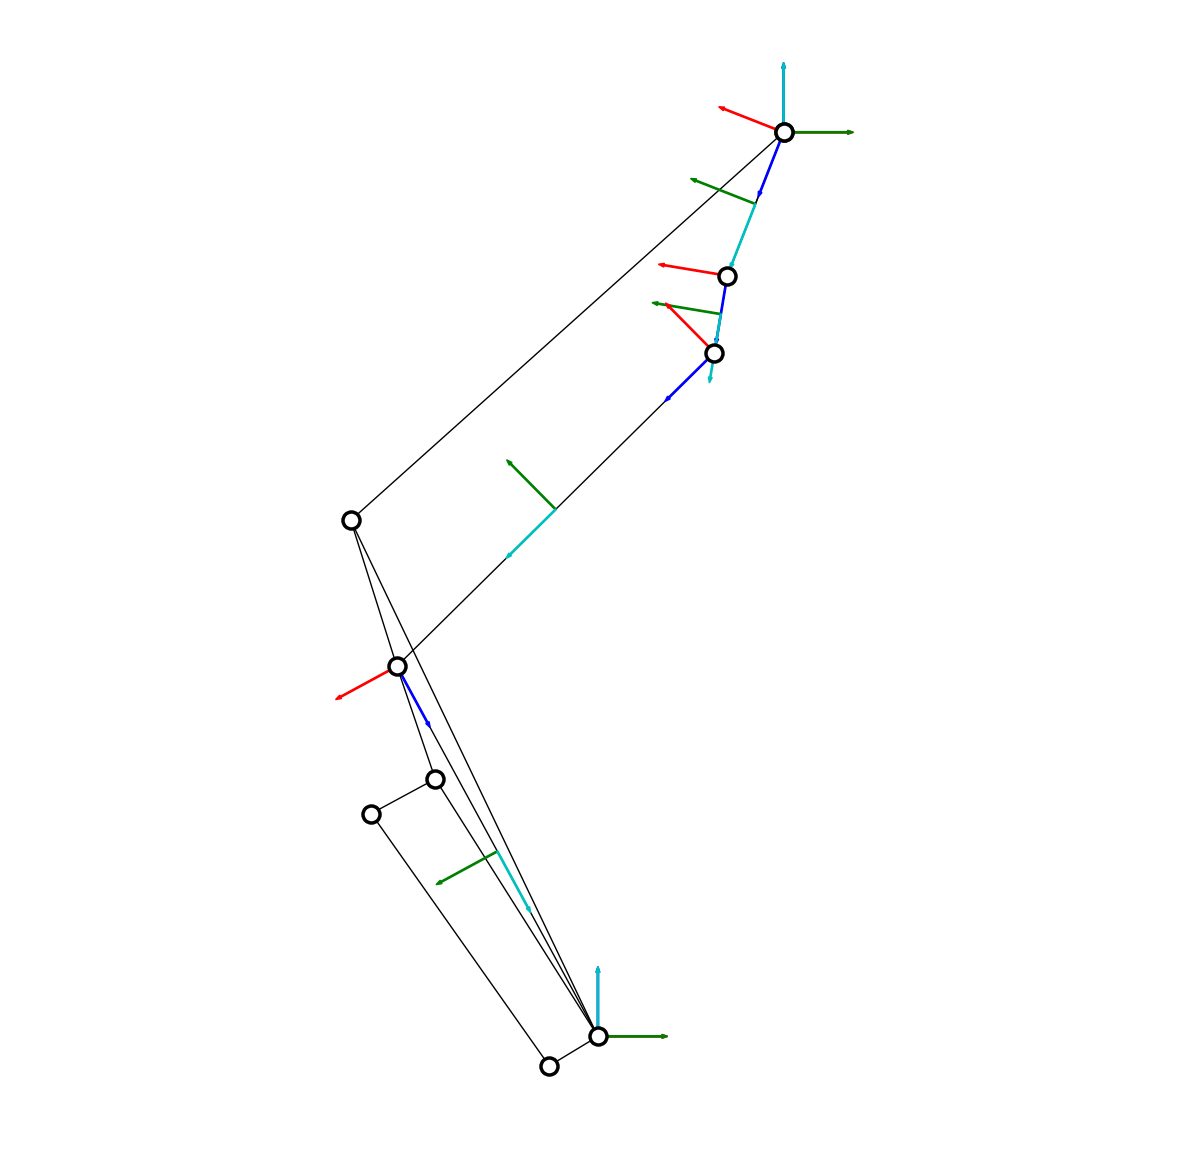

In [71]:
ex = np.array([1, 0, 0, 0])
ez = np.array([0, 0, 1, 0])
p = np.array([0, 0, 0, 1])
H = np.eye(4)
plt.figure(figsize=(15, 15))
plt.axis("equal")
nx.draw(
    graph,
    get_pos(graph),
    node_color="w",
    linewidths=2.5,
    edgecolors="k",
    node_shape="o",
    node_size=150,
    with_labels=False,
)
for name in main_branch:
    data = span_tree.nodes(data=True)[name]
    frame = data.get("frame", np.zeros(3))
    geom_l = data.get("frame_geom", np.zeros(3))
    H_w_l = data.get("H_w_l", np.eye(4))
    print(name, frame)
    if frame:
        Rmatr = R.from_quat(frame[1]).as_matrix()
        H = H_w_l  # H @ np.r_[np.c_[Rmatr, frame[0]], np.array([[0,0,0,1]])]
        ex_l = H @ ex
        ez_l = H @ ez
        p_l = H @ p
        # print(H)

        ex_g_l = H @ mr.RpToTrans(R.from_quat(geom_l[1]).as_matrix(), geom_l[0]) @ ex
        ez_g_l = H @ mr.RpToTrans(R.from_quat(geom_l[1]).as_matrix(), geom_l[0]) @ ez
        p_g_l = H @ mr.RpToTrans(R.from_quat(geom_l[1]).as_matrix(), geom_l[0]) @ p

        plt.arrow(p_l[0], p_l[2], ex_l[0] * 0.05, ex_l[2] * 0.05, color="r")
        plt.arrow(p_l[0], p_l[2], ez_l[0] * 0.05, ez_l[2] * 0.05, color="b")
        plt.arrow(p_g_l[0], p_g_l[2], ex_g_l[0] * 0.05, ex_g_l[2] * 0.05, color="g")
        plt.arrow(p_g_l[0], p_g_l[2], ez_g_l[0] * 0.05, ez_g_l[2] * 0.05, color="c")